In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)


In [ ]:
class PaperBeamShapingObjective:
    """
    Implements paper problem:
        min_{w,c_s} || D (c_s A w - v) ||_2^2
        s.t. w^H w = 1

    with closed-form c_s(w):
        c_s = (DAw)^H (Dv) / ||DAw||^2
    """

    def __init__(
        self,
        M=16,
        K=160,
        theta_grid=None,
        theta0_deg=0.0,
        mainlobe_db_drop=3.0,   # mainlobe: >= (peak - 3dB) on reference pattern
        w_main=10.0,
        w_side=1.0,
    ):
        self.M = int(M)
        self.K = int(K)
        self.theta0_deg = float(theta0_deg)
        self.mainlobe_db_drop = float(mainlobe_db_drop)
        self.w_main = float(w_main)
        self.w_side = float(w_side)

        if theta_grid is None:
            self.theta = np.linspace(-90, 90, self.K)
        else:
            self.theta = np.array(theta_grid, dtype=float)
            self.K = len(self.theta)

        # Build A: shape (K, M), row k = a(theta_k)^T
        self.A = np.vstack([self.array_response(th) for th in self.theta])

        # Build desired v and D using "mainlobe of reference" approach:
        # 1) reference beam w_ref steering at theta0
        w_ref = self.steering_beam(self.theta0_deg)
        pat_ref = self.pattern_linear(w_ref, self.theta)
        pat_ref_db = 10*np.log10(pat_ref + 1e-12)
        peak = np.max(pat_ref_db)

        main_mask = pat_ref_db >= (peak - self.mainlobe_db_drop)

        # desired response magnitude: 1 on mainlobe, 0 elsewhere
        v_mag = np.zeros(self.K, dtype=float)
        v_mag[main_mask] = 1.0

        # simplest desired phase: 0 (complex desired response)
        self.v = v_mag.astype(np.complex128)

        # diagonal weights D: larger in mainlobe, smaller elsewhere
        d = np.full(self.K, self.w_side, dtype=float)
        d[main_mask] = self.w_main

        # normalize weights so average squared weight ~ 1 (stabilizes scaling)
        d = d / np.sqrt(np.mean(d**2))
        self.D = d  # store diag as vector

        self.main_mask = main_mask
        self.w_ref = w_ref

    # ----- array/beam utilities -----
    def array_response(self, theta_deg):
        theta = np.deg2rad(theta_deg)
        m = np.arange(self.M)
        # ULA half-wavelength spacing
        return np.exp(1j * np.pi * m * np.sin(theta)).astype(np.complex128)

    def steering_beam(self, theta_deg):
        w = np.conj(self.array_response(theta_deg))  # common convention for transmit steering
        return w / (np.linalg.norm(w) + 1e-12)

    def gain_linear(self, w, theta_deg):
        a = self.array_response(theta_deg)
        return np.abs(np.vdot(a, w))**2

    def pattern_linear(self, w, theta_grid):
        a_mat = np.vstack([self.array_response(th) for th in theta_grid])  # (K,M)
        Aw = a_mat @ w
        return np.abs(Aw)**2

    # ----- paper objective pieces -----
    def optimal_cs(self, w_unit):
        Aw = self.A @ w_unit              # (K,)
        DAw = self.D * Aw                 # (K,)
        Dv = self.D * self.v              # (K,)

        denom = np.vdot(DAw, DAw) + 1e-12
        cs = np.vdot(DAw, Dv) / denom
        return cs

    def fitness(self, w):
        # enforce constraint ||w||=1
        w_unit = w / (np.linalg.norm(w) + 1e-12)

        cs = self.optimal_cs(w_unit)
        err = self.D * (cs * (self.A @ w_unit) - self.v)
        return float(np.vdot(err, err).real)

    def report_components(self, w):
        w_unit = w / (np.linalg.norm(w) + 1e-12)
        cs = self.optimal_cs(w_unit)
        err = self.D * (cs * (self.A @ w_unit) - self.v)
        return {
            "fitness": float(np.vdot(err, err).real),
            "cs": cs,
            "w_norm": float(np.linalg.norm(w_unit)),
        }


In [ ]:
class GABC:
    """
    Genetic Artificial Bee Colony optimizing w (magnitude+phase).
    Chromosome: [mag_0..mag_{M-1}, phase_0..phase_{M-1}]
      - mag in [0,1]
      - phase in [0, 2pi]
    """

    def __init__(self, objective: PaperBeamShapingObjective,
                 n_bees=30, max_iter=300, limit=20,
                 pc=0.8, pm=0.2):
        self.obj = objective
        self.M = objective.M
        self.dim = 2 * self.M

        self.n_bees = int(n_bees)
        self.max_iter = int(max_iter)
        self.limit = int(limit)
        self.pc = float(pc)
        self.pm = float(pm)

        self.best_solution = None
        self.best_fitness = float("inf")
        self.fitness_history = []

    # ----- encoding/decoding -----
    def decode(self, sol):
        mag = sol[:self.M]
        ph = sol[self.M:]
        w = mag * np.exp(1j * ph)
        return w / (np.linalg.norm(w) + 1e-12)

    def _clip_sol(self, sol):
        sol = sol.copy()
        sol[:self.M] = np.clip(sol[:self.M], 0.0, 1.0)
        sol[self.M:] = np.clip(sol[self.M:], 0.0, 2*np.pi)
        return sol

    # ----- init -----
    def initialize_population(self):
        pop = np.zeros((self.n_bees, self.dim), dtype=float)
        fit = np.zeros(self.n_bees, dtype=float)
        trial = np.zeros(self.n_bees, dtype=float)

        for i in range(self.n_bees):
            mag = np.random.rand(self.M)
            ph = np.random.rand(self.M) * 2*np.pi
            sol = np.concatenate([mag, ph])
            sol = self._clip_sol(sol)
            pop[i] = sol

            w = self.decode(sol)
            fit[i] = self.obj.fitness(w)

        return pop, fit, trial

    # ----- ABC phases -----
    def employed_bee_phase(self, pop, fit, trial):
        new_pop = pop.copy()
        new_fit = fit.copy()

        for i in range(self.n_bees):
            k = np.random.choice([j for j in range(self.n_bees) if j != i])

            phi = np.random.uniform(-1, 1, self.dim)
            v = pop[i] + phi * (pop[i] - pop[k])
            v = self._clip_sol(v)

            w_new = self.decode(v)
            f_new = self.obj.fitness(w_new)

            if f_new < fit[i]:
                new_pop[i] = v
                new_fit[i] = f_new
                trial[i] = 0
            else:
                trial[i] += 1

        return new_pop, new_fit, trial

    def onlooker_bee_phase(self, pop, fit, trial):
        # minimization: smaller fit => higher probability
        shifted = fit - np.min(fit) + 1e-12
        prob = (1.0 / shifted) / np.sum(1.0 / shifted)

        new_pop = pop.copy()
        new_fit = fit.copy()

        for _ in range(self.n_bees):
            i = np.random.choice(self.n_bees, p=prob)
            k = np.random.choice([j for j in range(self.n_bees) if j != i])

            phi = np.random.uniform(-1, 1, self.dim)
            v = pop[i] + phi * (pop[i] - pop[k])
            v = self._clip_sol(v)

            w_new = self.decode(v)
            f_new = self.obj.fitness(w_new)

            if f_new < fit[i]:
                new_pop[i] = v
                new_fit[i] = f_new
                trial[i] = 0
            else:
                trial[i] += 1

        return new_pop, new_fit, trial

    # ----- Genetic operators -----
    def crossover(self, p1, p2):
        if np.random.rand() > self.pc:
            return p1.copy(), p2.copy()

        point = np.random.randint(1, self.dim)
        c1 = np.concatenate([p1[:point], p2[point:]])
        c2 = np.concatenate([p2[:point], p1[point:]])
        return c1, c2

    def mutation(self, sol):
        m = sol.copy()
        for j in range(self.dim):
            if np.random.rand() < self.pm:
                if j < self.M:
                    m[j] = np.random.rand()
                else:
                    m[j] = np.random.rand() * 2*np.pi
        return self._clip_sol(m)

    def genetic_operators(self, pop, fit):
        idx = np.argsort(fit)
        elite_size = self.n_bees // 2
        elites = pop[idx[:elite_size]]

        new_pop = []
        while len(new_pop) < self.n_bees:
            i1, i2 = np.random.choice(elite_size, 2, replace=False)
            p1, p2 = elites[i1], elites[i2]
            c1, c2 = self.crossover(p1, p2)
            c1 = self.mutation(c1)
            c2 = self.mutation(c2)
            new_pop.extend([c1, c2])

        new_pop = np.array(new_pop[:self.n_bees])
        new_fit = np.zeros(self.n_bees, dtype=float)
        for i in range(self.n_bees):
            new_fit[i] = self.obj.fitness(self.decode(new_pop[i]))

        return new_pop, new_fit

    # ----- Scout -----
    def scout_bee_phase(self, pop, fit, trial):
        for i in range(self.n_bees):
            if trial[i] > self.limit:
                mag = np.random.rand(self.M)
                ph = np.random.rand(self.M) * 2*np.pi
                sol = self._clip_sol(np.concatenate([mag, ph]))
                pop[i] = sol
                fit[i] = self.obj.fitness(self.decode(sol))
                trial[i] = 0
        return pop, fit, trial

    # ----- Main loop -----
    def optimize(self, genetic_every=10, verbose_every=10):
        pop, fit, trial = self.initialize_population()

        b = np.argmin(fit)
        self.best_fitness = float(fit[b])
        self.best_solution = pop[b].copy()
        self.fitness_history = [self.best_fitness]

        for it in range(1, self.max_iter + 1):
            pop, fit, trial = self.employed_bee_phase(pop, fit, trial)
            pop, fit, trial = self.onlooker_bee_phase(pop, fit, trial)

            if genetic_every and (it % genetic_every == 0):
                pop, fit = self.genetic_operators(pop, fit)
                trial[:] = 0

            pop, fit, trial = self.scout_bee_phase(pop, fit, trial)

            b = np.argmin(fit)
            if fit[b] < self.best_fitness:
                self.best_fitness = float(fit[b])
                self.best_solution = pop[b].copy()

            self.fitness_history.append(self.best_fitness)

            if verbose_every and (it % verbose_every == 0):
                print(f"Iter {it:4d} | Best Fitness = {self.best_fitness:.6e}")

        return self.decode(self.best_solution)


In [ ]:
def print_w_components(w_vector):
    """Prints the magnitude and phase of each component of a complex vector w."""
    print("\n=== WEIGHT COMPONENTS (w) ===")
    for i, val in enumerate(w_vector):
        magnitude = np.abs(val)
        phase = np.angle(val) # in radians
        print(f"w[{i:2d}]: Mag = {magnitude:.4f}, Phase = {np.rad2deg(phase):.2f}° ({phase:.4f} rad)")

Iter   10 | Best Fitness = 2.078536e+01
Iter   20 | Best Fitness = 9.958285e+00
Iter   30 | Best Fitness = 9.958285e+00
Iter   40 | Best Fitness = 8.228355e+00
Iter   50 | Best Fitness = 7.881382e+00
Iter   60 | Best Fitness = 7.881382e+00
Iter   70 | Best Fitness = 7.881382e+00
Iter   80 | Best Fitness = 7.881382e+00
Iter   90 | Best Fitness = 7.881382e+00
Iter  100 | Best Fitness = 7.881382e+00
Iter  110 | Best Fitness = 7.881382e+00
Iter  120 | Best Fitness = 7.881382e+00
Iter  130 | Best Fitness = 7.847262e+00
Iter  140 | Best Fitness = 7.847262e+00
Iter  150 | Best Fitness = 7.847262e+00
Iter  160 | Best Fitness = 6.600343e+00
Iter  170 | Best Fitness = 6.600343e+00
Iter  180 | Best Fitness = 6.600343e+00
Iter  190 | Best Fitness = 6.600343e+00
Iter  200 | Best Fitness = 6.600343e+00
Iter  210 | Best Fitness = 6.600343e+00
Iter  220 | Best Fitness = 6.600343e+00
Iter  230 | Best Fitness = 6.600343e+00
Iter  240 | Best Fitness = 6.600343e+00
Iter  250 | Best Fitness = 6.600343e+00


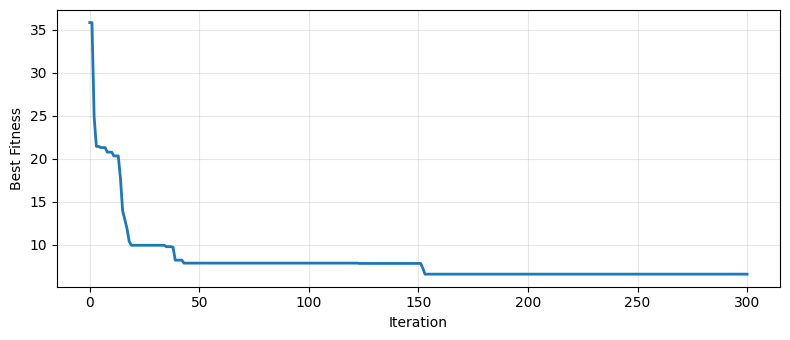

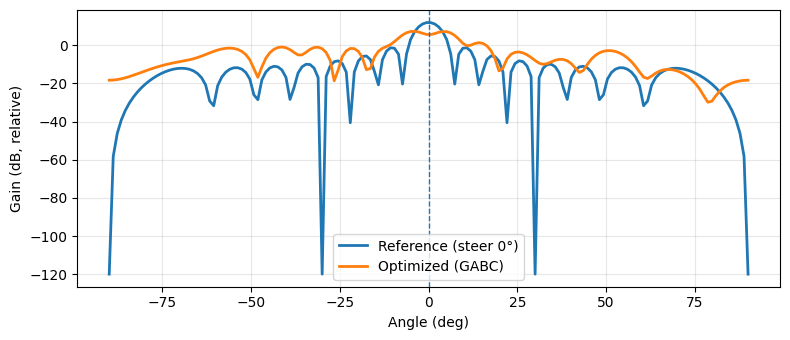

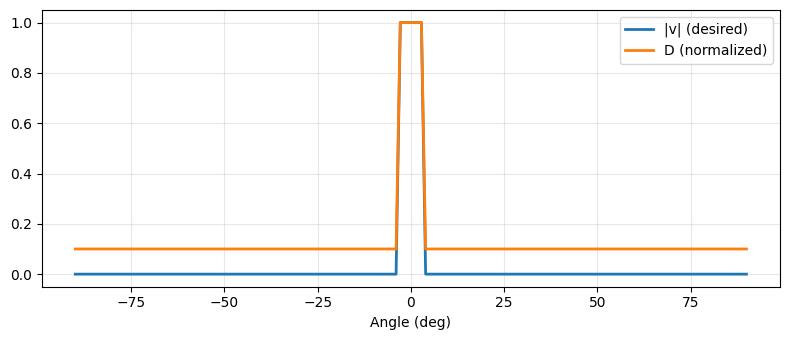

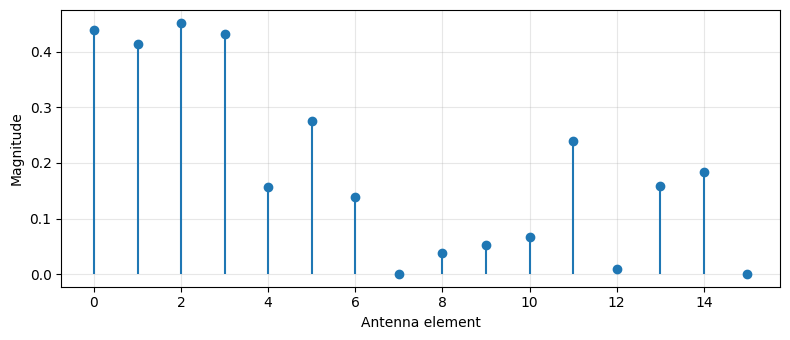

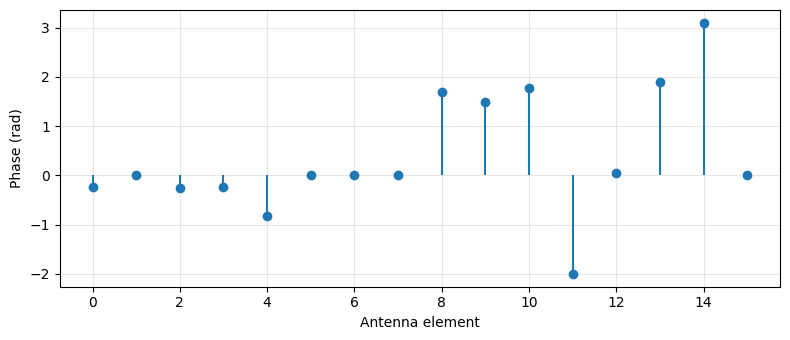


=== WEIGHT COMPONENTS (w) ===
w[ 0]: Mag = 0.4400, Phase = -13.74° (-0.2397 rad)
w[ 1]: Mag = 0.4131, Phase = 0.00° (0.0000 rad)
w[ 2]: Mag = 0.4525, Phase = -14.96° (-0.2611 rad)
w[ 3]: Mag = 0.4315, Phase = -13.03° (-0.2275 rad)
w[ 4]: Mag = 0.1573, Phase = -47.00° (-0.8203 rad)
w[ 5]: Mag = 0.2754, Phase = 0.00° (0.0000 rad)
w[ 6]: Mag = 0.1394, Phase = 0.00° (0.0000 rad)
w[ 7]: Mag = 0.0000, Phase = 0.00° (0.0000 rad)
w[ 8]: Mag = 0.0373, Phase = 96.71° (1.6879 rad)
w[ 9]: Mag = 0.0518, Phase = 85.67° (1.4953 rad)
w[10]: Mag = 0.0677, Phase = 101.76° (1.7760 rad)
w[11]: Mag = 0.2389, Phase = -114.80° (-2.0036 rad)
w[12]: Mag = 0.0084, Phase = 3.16° (0.0552 rad)
w[13]: Mag = 0.1583, Phase = 108.16° (1.8877 rad)
w[14]: Mag = 0.1844, Phase = 177.62° (3.1000 rad)
w[15]: Mag = 0.0000, Phase = -0.00° (-0.0000 rad)


In [ ]:
# --- Create objective (paper LS) ---
obj = PaperBeamShapingObjective(
    M=16,
    K=160,                 # typical smooth grid
    theta0_deg=0.0,
    mainlobe_db_drop=3.0,  # mainlobe region from reference
    w_main=10.0,
    w_side=1.0
)

# --- Run GABC ---
gabc = GABC(obj, n_bees=30, max_iter=300, limit=20, pc=0.8, pm=0.2)
w_best = gabc.optimize(genetic_every=10, verbose_every=10)

rep = obj.report_components(w_best)
print("\n=== FINAL REPORT ===")
print("Best fitness:", rep["fitness"])
print("Best c_s:", rep["cs"])
print("||w||:", rep["w_norm"])

# --- Plots ---
theta = obj.theta
pat_best = obj.pattern_linear(w_best, theta)
pat_best_db = 10*np.log10(pat_best + 1e-12)

pat_ref = obj.pattern_linear(obj.w_ref, theta)
pat_ref_db = 10*np.log10(pat_ref + 1e-12)

# 1) Convergence
plt.figure(figsize=(8, 3.5))
plt.plot(gabc.fitness_history, linewidth=2)
plt.xlabel("Iteration")
plt.ylabel("Best Fitness")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2) Pattern compare
plt.figure(figsize=(8, 3.5))
plt.plot(theta, pat_ref_db, linewidth=2, label="Reference (steer 0°)")
plt.plot(theta, pat_best_db, linewidth=2, label="Optimized (GABC)")
plt.axvline(0, linestyle="--", linewidth=1)
plt.xlabel("Angle (deg)")
plt.ylabel("Gain (dB, relative)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 3) Desired v magnitude + weights D
plt.figure(figsize=(8, 3.5))
plt.plot(theta, np.abs(obj.v), linewidth=2, label="|v| (desired)")
plt.plot(theta, obj.D / np.max(obj.D), linewidth=2, label="D (normalized)")
plt.xlabel("Angle (deg)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 4) Beam weights (mag/phase)
w_mag = np.abs(w_best)
w_ph = np.angle(w_best)

plt.figure(figsize=(8, 3.5))
plt.stem(np.arange(obj.M), w_mag, basefmt=" ")
plt.xlabel("Antenna element")
plt.ylabel("Magnitude")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 3.5))
plt.stem(np.arange(obj.M), w_ph, basefmt=" ")
plt.xlabel("Antenna element")
plt.ylabel("Phase (rad)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print_w_components(w_best)